In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np




In [2]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"CORRECTLY_{CHECKPOINT}_ckpt_short_more_data"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1"
EPOCHS = 101
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(GIF_PATH, exist_ok=True)


In [3]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [4]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


In [5]:
@jax.jit
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))

# Data creation

In [6]:
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

2025-08-20 15:38:20.400539: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


data transformation

check if transitions are correct

In [7]:
for i in range(30):
    print("________________")
    print(timesteps.grid[i, 0])
    print(timesteps.goal[i, 0])
    

________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 6  0  0  0  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  3  0  0  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  0  3  0  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  0  0  3  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  0  0  0  0]
 [ 2  0  1  6  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
_____

check if envs are differen

In [8]:
timesteps.grid[0, :10]

Array([[[ 0, 10,  2,  0,  0],
        [ 2,  1,  1,  0,  0],
        [ 6,  0,  0,  0,  0],
        [ 2,  0,  1,  2,  0],
        [ 0,  0,  0,  1,  1]],

       [[ 0,  2,  0,  0,  0],
        [ 1,  0,  0,  0,  1],
        [ 6,  0,  1,  0,  0],
        [ 0,  1,  0,  2,  0],
        [ 0,  2,  2,  0,  1]],

       [[ 0,  0,  0,  1,  1],
        [ 0,  0,  2,  0,  1],
        [ 0,  2,  1,  0,  0],
        [ 3,  0,  0,  0,  0],
        [ 0,  1,  2,  2,  2]],

       [[ 0,  0,  1,  2,  2],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  2,  3,  0],
        [ 0,  1,  0,  0,  0],
        [ 0,  0,  1,  0,  0]],

       [[ 2, 10,  0,  1,  0],
        [ 0,  0,  0,  2,  0],
        [ 1,  0,  0,  1,  3],
        [ 0,  0,  0,  0,  2],
        [ 1,  2,  1, 10,  2]],

       [[ 2,  0,  3,  0,  0],
        [ 0,  0,  0,  2,  0],
        [10,  1,  0,  1,  0],
        [10,  1,  2,  0,  2],
        [ 0,  1,  2,  0,  1]],

       [[ 1,  0,  0,  0,  0],
        [ 1,  0,  2,  0,  0],
        [ 3,  0,  2,  1,  1]

In [9]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal
tr_states.shape, tr_goals.shape, tr_actions.shape

((100, 1024, 5, 5), (100, 1024, 5, 5), (100, 1024))

In [10]:
tr_states, tr_goals, tr_actions = tr_states.reshape((-1, tr_states.shape[-2],tr_states.shape[-1])), tr_goals.reshape((-1, tr_goals.shape[-2],tr_goals.shape[-1])), tr_actions.reshape((-1,))
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 5, 5), (102400, 5, 5), (102400,))

In [11]:
tr_states, tr_goals = tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1)
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 25), (102400, 25), (102400,))

In [12]:
timesteps.grid[0,0]

Array([[ 0, 10,  2,  0,  0],
       [ 2,  1,  1,  0,  0],
       [ 6,  0,  0,  0,  0],
       [ 2,  0,  1,  2,  0],
       [ 0,  0,  0,  1,  1]], dtype=int8)

In [13]:
for i in range(0, 102400, 1024):
    print("________________")
    print(tr_states[i].reshape(5,5))
    print(tr_goals[i].reshape(5,5))

________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 3 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 3 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 3 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 1 3 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 5 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 4 1]]
[[0 1 1 0 0]
 [1 0 0 0 

I'm calculating q values with goals, which are from environment!!!! 

In [15]:
qs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    q1, q2 = agent.network.select('critic')(tr_states, tr_goals, tr_actions)
    q = np.concat([q1, q2])
    qs.append(q)
qs = np.array(qs)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [16]:
qs.shape

(6, 204800)

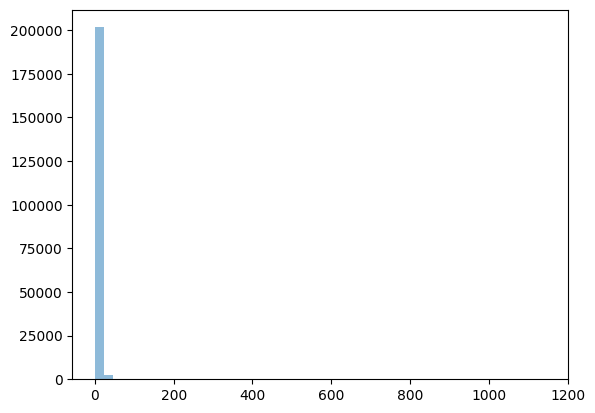

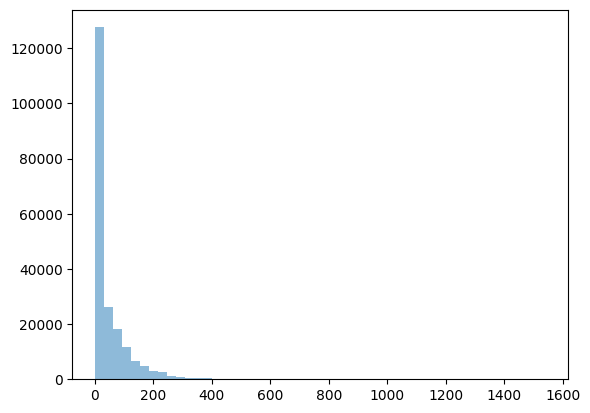

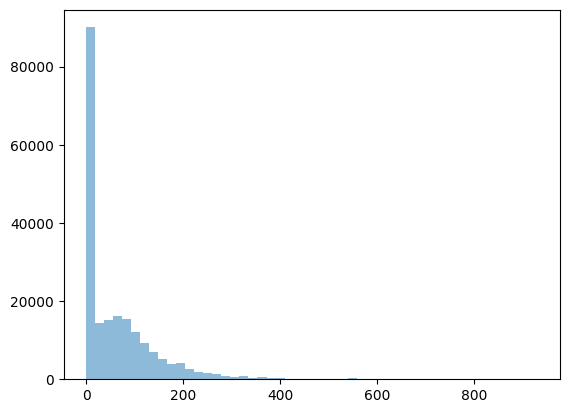

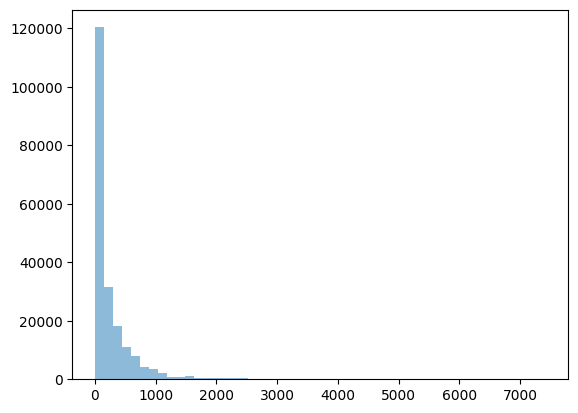

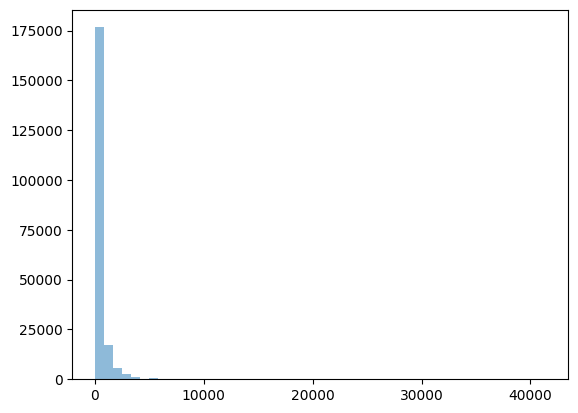

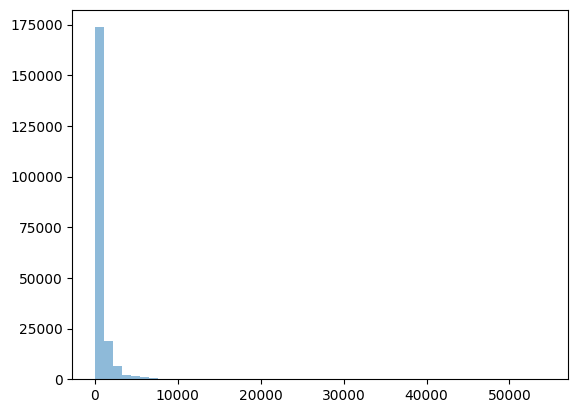

In [17]:
for i in range(qs.shape[0]):
    plt.hist(qs[i], bins=50, alpha=0.5, label=f'ckpt {i*CHKPT_EVERY}')
    plt.show()

In [18]:
# Find top N indices for each row in qs
N = 5000
top_indices_per_row = [np.argsort(qs[row])[-N:][::-1] for row in range(1, qs.shape[0])]

# Compute intersection between all rows' top indices
intersection = set(top_indices_per_row[0])
for idxs in top_indices_per_row[1:]:
    intersection &= set(idxs)

print(f"Intersection of top {N} indices across all rows:", intersection)
print(f"Number of intersecting indices: {len(intersection)}")

Intersection of top 5000 indices across all rows: set()
Number of intersecting indices: 0


In [19]:
intersection = np.array(list(intersection))

debugging highest values

In [20]:
intersection[:10]

array([], dtype=float64)

In [ ]:
# for idx in range(10):
#     print("=================================")
#     print(tr_states[intersection[idx]].reshape(5,5))
#     print("")
#     print(tr_goals[intersection[idx]].reshape(5,5))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [23]:
intersection[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
for idx in range(10000):
    idx_tmp = idx
    # print(idx_tmp)
    # print(tr_states[idx_tmp].reshape(5,5))
    print((tr_states[idx_tmp]==tr_states[0]).all())

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

In [25]:
for idx in range(10000):
    idx_tmp = intersection[0] + idx
    # print(idx_tmp)
    # print(tr_states[idx_tmp].reshape(5,5))
    print((tr_states[idx_tmp]==tr_states[intersection[0]]).all())

IndexError: index 0 is out of bounds for axis 0 with size 0

# Q plots

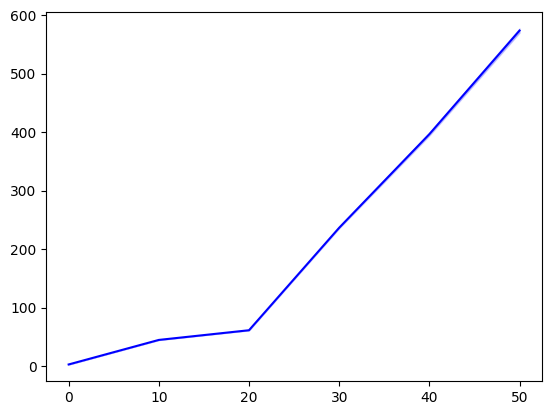

In [27]:
mean_q = np.array(qs).mean(axis=1)
std_err_q = np.array(qs).std(axis=1) / np.sqrt(np.array(qs).shape[1])
x = np.arange(0, CHECKPOINT+1, CHKPT_EVERY)
plt.plot(x, mean_q, label='Mean Q', color='blue')
plt.fill_between(x, mean_q - std_err_q, mean_q + std_err_q, color='blue', alpha=0.2, label='StdErr Q')


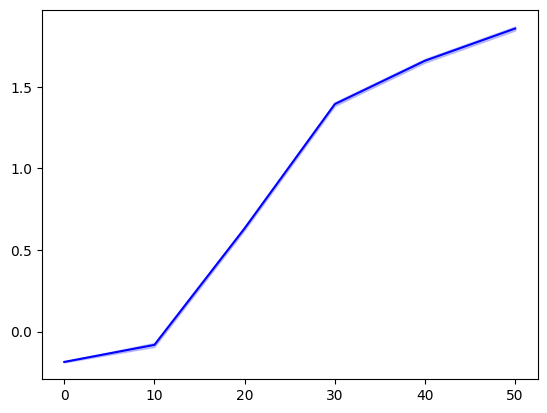

In [28]:
qs_log = value_transform(qs)
mean_q = np.array(qs_log).mean(axis=1)
std_err_q = np.array(qs_log).std(axis=1) / np.sqrt(np.array(qs_log).shape[1])
x = np.arange(0, CHECKPOINT+1, CHKPT_EVERY)
plt.plot(x, mean_q, label='Mean Q', color='blue')
plt.fill_between(x, mean_q - std_err_q, mean_q + std_err_q, color='blue', alpha=0.2, label='StdErr Q')


/tmp/ipykernel_1834589/1582629923.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(qs.T, labels=[f'ckpt {i}' for i in range(0, CHECKPOINT+1, CHKPT_EVERY)])


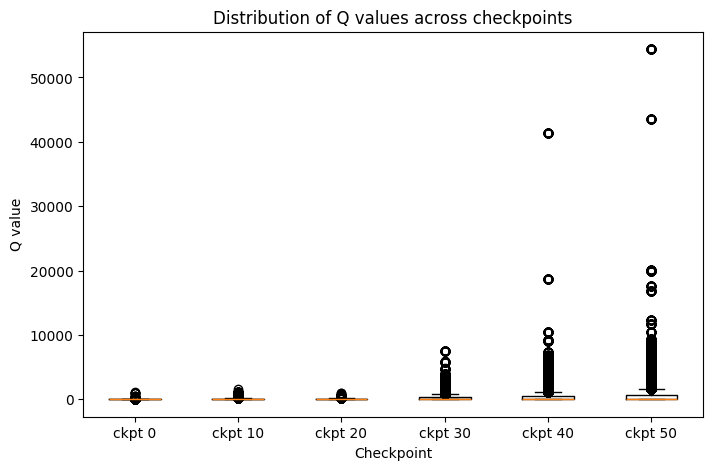

In [30]:
plt.figure(figsize=(8, 5))
plt.boxplot(qs.T, labels=[f'ckpt {i}' for i in range(0, CHECKPOINT+1, CHKPT_EVERY)])
plt.xlabel('Checkpoint')
plt.ylabel('Q value')
plt.title('Distribution of Q values across checkpoints')
plt.show()

/tmp/ipykernel_304549/331713933.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(qs_log.T, labels=[f'ckpt {i}' for i in range(0, 101, CHKPT_EVERY)])


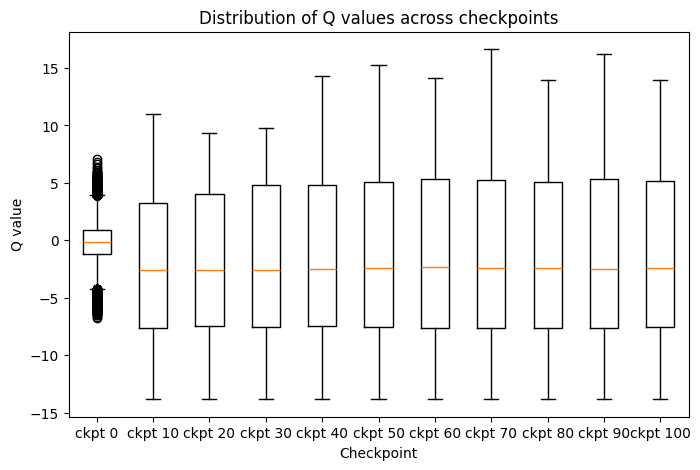

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(qs_log.T, labels=[f'ckpt {i}' for i in range(0, 101, CHKPT_EVERY)])
plt.xlabel('Checkpoint')
plt.ylabel('Q value')
plt.title('Distribution of Q values across checkpoints')
plt.show()

/tmp/ipykernel_1834589/2809808781.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', qs_log.shape[0])


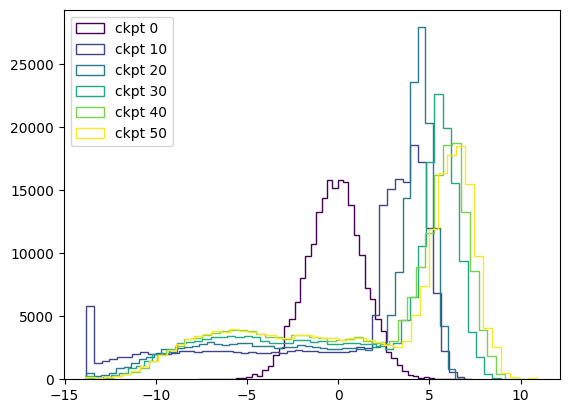

In [33]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', qs_log.shape[0])
for i in range(qs.shape[0]):
    plt.hist(qs_log[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

# Dirty

In [34]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [35]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


In [36]:
@jax.jit
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))

In [37]:
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

In [38]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal
tr_states.shape, tr_goals.shape, tr_actions.shape

((100, 1024, 5, 5), (100, 1024, 5, 5), (100, 1024))

In [39]:
tr_states, tr_goals, tr_actions = tr_states.reshape((-1, tr_states.shape[-2],tr_states.shape[-1])), tr_goals.reshape((-1, tr_goals.shape[-2],tr_goals.shape[-1])), tr_actions.reshape((-1,))
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 5, 5), (102400, 5, 5), (102400,))

In [40]:
tr_states, tr_goals = tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1)
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 25), (102400, 25), (102400,))

In [43]:
qs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    q1, q2 = agent.network.select('critic')(tr_states, tr_goals, tr_actions)
    q = np.concat([q1, q2])
    qs.append(q)
qs = np.array(qs)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [44]:
qs_log = value_transform(qs)

/tmp/ipykernel_1834589/1969038191.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', qs_log.shape[0])


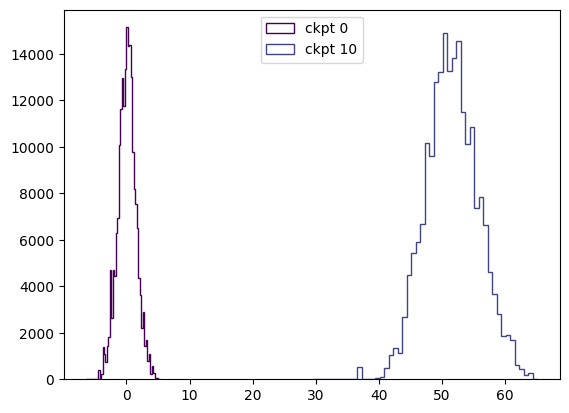

In [48]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', qs_log.shape[0])
for i in range(2):
    plt.hist(qs_log[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

# Dirty 2

In [49]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=9,
        number_of_boxes_max=9,
        number_of_moving_boxes_max=9
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [50]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


In [51]:
@jax.jit
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))

In [52]:
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

In [53]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal
tr_states.shape, tr_goals.shape, tr_actions.shape

((100, 1024, 5, 5), (100, 1024, 5, 5), (100, 1024))

In [54]:
tr_states, tr_goals, tr_actions = tr_states.reshape((-1, tr_states.shape[-2],tr_states.shape[-1])), tr_goals.reshape((-1, tr_goals.shape[-2],tr_goals.shape[-1])), tr_actions.reshape((-1,))
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 5, 5), (102400, 5, 5), (102400,))

In [55]:
tr_states, tr_goals = tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1)
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 25), (102400, 25), (102400,))

In [56]:
qs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    q1, q2 = agent.network.select('critic')(tr_states, tr_goals, tr_actions)
    q = np.concat([q1, q2])
    qs.append(q)
qs = np.array(qs)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [57]:
qs_log = value_transform(qs)

/tmp/ipykernel_1834589/4069156949.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', qs_log.shape[0])


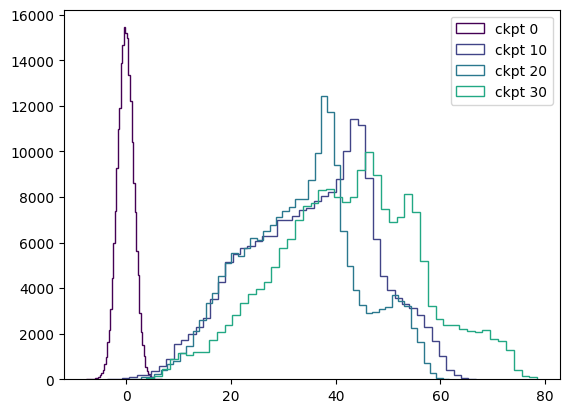

In [61]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', qs_log.shape[0])
for i in range(4):
    plt.hist(qs_log[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()